# Comments

Base implementation for the Qonv2D operation.
A portion of an image of shape (2, 2) is Qonvolved with a (2, 2)
Filter by means of a quantum circuit.

For the quantum circuit part, 4 qubits are used. A U3 gate is applied to each
qubit, with the form

$qc.u3(FOCUS[0, 0] * FILTER[0, 0], FOCUS[0, 0] * FILTER[0, 1], FOCUS[0, 0] * FILTER[1, 0], q[0])$

$qc.u3(FOCUS[0, 1] * FILTER[0, 0], FOCUS[0, 1] * FILTER[0, 1], FOCUS[0, 1] * FILTER[1, 0], q[1])$

$qc.u3(FOCUS[1, 0] * FILTER[0, 0], FOCUS[1, 0] * FILTER[0, 1], FOCUS[1, 0] * FILTER[1, 0], q[2])$

$qc.u3(FOCUS[1, 1] * FILTER[0, 0], FOCUS[1, 1] * FILTER[0, 1], FOCUS[1, 1] * FILTER[1, 0], q[3])$

Hadamard gates are applied to each qubit before and after each u3 gate. A multicontrolled X gate
is applied to an ancillary qubit with all the four previous qubits as control.

The final element in the FILTER is used to modulate the ouput of the circuit, with the form
$(\frac{readouts.counts('1')}{shots}) * FILTER[1, 1]$

Ideally, the element of each filter in FILTERS can be updated through an optimization algorithm
to produced better results.

# Imports

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions.unitary import unitary
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
from qiskit.providers.aer import QasmSimulator
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

backend = QasmSimulator(configuration = {'method' : 'density_matrix'})
M_simulator = backend


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import misc
import cv2

# Functions definitions

In [2]:
def draw(qc):
    return circuit_drawer(qc, scale = 1, cregbundle  = False, output = 'mpl', fold = 24, initial_state = True)
def hist(readout):
    return plot_histogram(readout)

In [3]:
def convolution(FOCUS, FILTER, shots = 8192):
    '''
    FOCUS = [[F00, F01],
             [F10, F11]]
    FILTER = [[FI00, FI01],
              [FI10, FI11]]
    '''
    q = QuantumRegister(4, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'q_circ')

    qc.h(q)

    qc.u3(FOCUS[0, 0] * FILTER[0, 0], FOCUS[0, 0] * FILTER[0, 1], FOCUS[0, 0] * FILTER[1, 0], q[0])

    qc.u3(FOCUS[0, 1] * FILTER[0, 0], FOCUS[0, 1] * FILTER[0, 1], FOCUS[0, 1] * FILTER[1, 0], q[1])

    qc.u3(FOCUS[1, 0] * FILTER[0, 0], FOCUS[1, 0] * FILTER[0, 1], FOCUS[1, 0] * FILTER[1, 0], q[2])

    qc.u3(FOCUS[1, 1] * FILTER[0, 0], FOCUS[1, 1] * FILTER[0, 1], FOCUS[1, 1] * FILTER[1, 0], q[3])
    
    qc.h(q)

    qc.mct(q, a, None, mode = 'noancilla')

    qc.measure(a[0], c)

    #transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1)
    #job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    job = execute(qc, M_simulator, shots = shots, optimization_level = 1)
    results = job.result()

    readout = results.get_counts()
    convolution = (readout.get('1', 0) / shots) * FILTER[1, 1]
    return convolution, readout, qc

In [4]:
def Qonv2D(filters = 1, kernel_size = (2, 2), stride = (1, 1), image = None):
    np.random.seed(465)
    N_FILTERS = filters
    KERNEL = kernel_size
    STRIDE = stride
    FILTERS = np.random.random(size = (N_FILTERS, KERNEL[0], KERNEL[1])) * np.pi
    CONV_SHAPE = ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1, N_FILTERS)
    '''
    CONV_SHAPE = ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1)
    CONV_OUTPUT = [] # shape = (Filters, CONV_IMAGE.shape)
    for FILTER in FILTERS:
        CONV_IMAGE = [] # shape = (((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1))
        for row in range(0, image.shape[0] - KERNEL[0] + 1, STRIDE[0]):
            for col in range(0, image.shape[1] - KERNEL[1] + 1, STRIDE[1]):
                focus = image[row : row + KERNEL[0], col : col + KERNEL[1]]
                convol = convolution(focus, FILTER, shots = 100)
                CONV_IMAGE.append(convol[0])
        CONV_OUTPUT.append(np.array(CONV_IMAGE).reshape(CONV_SHAPE))'''
    CONV_IMAGE = [[] for _ in range(N_FILTERS)] # shape = (((image.shape[0] - KERNEL[0]) // STRIDE + 1, (image.shape[0] - KERNEL[0]) // STRIDE + 1))
    for row in range(0, image.shape[0] - KERNEL[0] + 1, STRIDE[0]):
        for col in range(0, image.shape[1] - KERNEL[1] + 1, STRIDE[1]):
            for index, FILTER in enumerate(FILTERS):
                focus = image[row : row + KERNEL[0], col : col + KERNEL[1]]
                convol = convolution(focus, FILTER, shots = 100)
                CONV_IMAGE[index].append(convol[0])
    CONV_OUTPUT = np.stack(CONV_IMAGE, axis = -1)
    CONV_OUTPUT = CONV_OUTPUT.reshape(CONV_SHAPE)
    return CONV_OUTPUT

In [5]:
def qonv2D(FILTERS = None, kernel_size = (2, 2), stride = (1, 1), image = None):
    KERNEL = kernel_size
    STRIDE = stride
    N_FILTERS = FILTERS.shape[0]
    CONV_SHAPE = ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1, N_FILTERS)
    
    CONV_IMAGE = [[] for _ in range(N_FILTERS)]
    for row in range(0, image.shape[0] - KERNEL[0] + 1, STRIDE[0]):
        for col in range(0, image.shape[1] - KERNEL[1] + 1, STRIDE[1]):
            for index, FILTER in enumerate(FILTERS):
                focus = image[row : row + KERNEL[0], col : col + KERNEL[1]]
                convol = convolution(focus, FILTER, shots = 8192)
                CONV_IMAGE[index].append(convol[0])
    CONV_OUTPUT = np.stack(CONV_IMAGE, axis = -1)
    CONV_OUTPUT = CONV_OUTPUT.reshape(CONV_SHAPE)
    return CONV_OUTPUT

# Testing

In [13]:
from tensorflow.keras.datasets import mnist
# Loading MNIST
((x_train, y_train), (x_test, y_test)) = mnist.load_data()

# Adding a channel dimension and scaling
#x_train = np.expand_dims(x_train, axis = -1)
#x_test = np.expand_dims(x_test, axis = -1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [23]:
np.random.seed(564)
image = np.random.random(size = (28, 28)) # Random 'image' generation
#image = misc.ascent() # Stock image
# Number image from Semeion Handwritten Digits Dataset
#image = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(16, 16)
image = x_train[0] # MNIST Sample

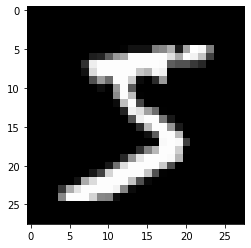

In [24]:
plt.imshow(image, cmap = 'gray')
plt.show()

In [25]:
# Creating random filters
np.random.seed(1918)
FILTERS = np.random.random(size = (4, 2, 2)) * np.pi

In [26]:
# Executing convolutions
CONV_OUTPUT = qonv2D(FILTERS, (2, 2), (1, 1), image)

In [27]:
# Convolution output shape
CONV_OUTPUT.shape

(27, 27, 4)

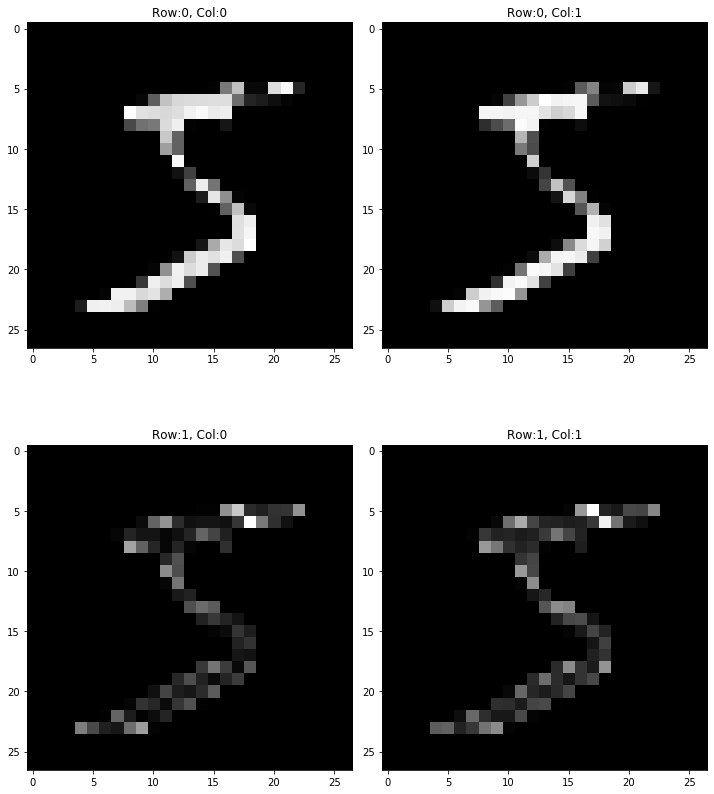

In [28]:
h, w = 10, 10        # for raster image
nrows, ncols = 2, 2  # array of sub-plots
figsize = [10, 12]     # figure size, inches

# prep (x,y) for extra plotting on selected sub-plots

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    axi.imshow(CONV_OUTPUT[:, :, i], cmap = 'gray')
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))

# one can access the axes by ax[row_id][col_id]
# do additional plotting on ax[row_id][col_id] of your choice
#ax[0][2].plot(xs, 3*ys, color='red', linewidth=3)
#ax[4][3].plot(ys**2, xs, color='green', linewidth=3)

plt.tight_layout(True)
plt.show()

# Comparison

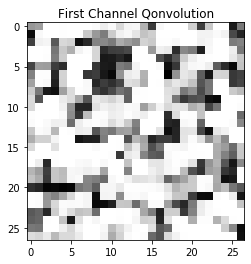

In [102]:
plt.imshow(np.array(CONV_OUTPUT[:, :, 0]), cmap = 'gray_r')
plt.title("First Channel Qonvolution")
plt.show()

In [103]:
# Classical SciPy convolution on first FILTER
ascent = misc.ascent()
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j], [-10+0j, 0+ 0j, +10 +0j], [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy
grad = signal.convolve2d(image, FILTERS[0], boundary='symm', mode='valid')
#grad = signal.convolve2d(ascent, FILTERS[0], boundary='symm', mode='valid')
#grad = signal.convolve2d(ascent, scharr, boundary='symm', mode='valid')

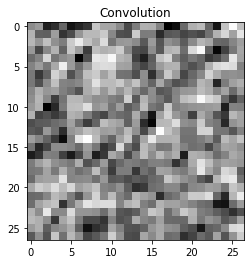

In [104]:
plt.imshow(np.absolute(grad), cmap='gray')
plt.title('Convolution')
plt.show()